In [26]:
using DifferentialEquations, Plots, LinearAlgebra
using ComponentArrays
using FiniteDiff

## Cannonball Trajectory Optimization Examples

Based the work presented here: https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/canon.html

Boundary value problem (BVP) to aim a cannon to hit a target at a fixed location. 

Using a single shooting method to turn a BVP into an IVP and iterate upon initial guesses to adjust states to match boundary conditions

Assume cannon is at a variable angle and we can adjust the initial velocity magnitude of the projectile. Cannonball is modeled as a point mass. Air friction is modeled using quadratic drag

States:

[x y x_d y_d]

Inputs:

[v_mag theta] (Initial velocity of projectile and angle of cannon)

In [78]:
# Parameters
p = ComponentArray(
    c = 0.4, # Quadratic Drag Coefficient 
    m = 1.0, # Point mass 
    g = 9.8
)

# Goal
# X, y
x_goal = [6.0; 0.0]

# Intial conditions/guess
# x, y, ẋ, ẏ
x0 = [0.0; 0.0; 0.0; 0.0]


4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [79]:
function cannon_dynamics(s, p, t)
    # State vector: [x, y, x_d, y_d
    dx = [0.0; 0.0; 0.0; 0.0]
    dx[1] = s[3] #xd
    dx[2] = s[4] #yd
    v = sqrt(dx[1]^2 + dx[2]^2)
    dx[3] = -(p.c/p.m) * v *s[3] #xdd
    dx[4] = -p.g - (p.c/p.m)*v * s[4] #ydd

    return dx
end

tspan = (0.0, 7.0)

u0 = ComponentArray(
    vmag = 9.0, # initial speed
    theta = 45 * pi/180 # rad
)

x0[3] = u0.vmag*cos(u0.theta)
x0[4] = u0.vmag*sin(u0.theta)

display(x0)



4-element Vector{Float64}:
 0.0
 0.0
 6.3639610306789285
 6.363961030678928

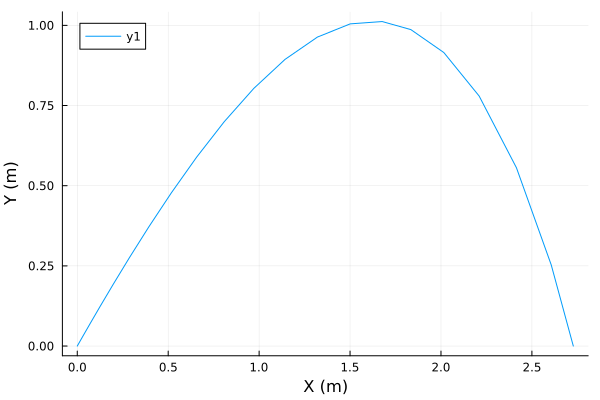

In [80]:
function condition(s, t, integrator) # checkw hen condition == 0
    s[2]
end

function affect!(integrator)
    terminate!(integrator)
end
cb = ContinuousCallback(condition, affect!)


prob = ODEProblem(cannon_dynamics, x0, tspan, p)

sol = solve(prob, RK4(), callback = cb)
# State vector: [x, y, x_d, y_d]
plot(sol[1,:], sol[2,:], xlabel="X (m)", ylabel="Y (m)")
#size(sol)

In [109]:
# Cost function
function cost(s, x_goal)
    J = [0.0; 0.0]
    J[1] = (s[1] - x_goal[1])^2
    J[2] =  (s[2] - x_goal[2])^2

    return J
end

cost (generic function with 1 method)

In [82]:
A = FiniteDiff.finite_difference_jacobian(dx->cost(dx, x_goal), [x0[1]; x0[2]])
#= function cost(J, s, x_goal)
    J = (s[1] - x_goal[1])^2 + (s[2] - x_goal[2])^2
end =#
display(A)
x_final = [sol[1,end]; sol[2,end]]
J = cost(x_final, x_goal)
print(String("Initial Cost: $(J)"))
(A \ J)

2×2 Matrix{Float64}:
 -12.0  0.0
   0.0  1.49012e-8

Initial Cost: [10.708057407122043, 1.718922568020989e-31]

2-element Vector{Float64}:
 -0.8923381172601702
  1.153549408438513e-23

In [110]:
# thanks https://github.com/JuliaDiff/FiniteDiff.jl
# Single shooting using Newton's Method:
# x[k+1] = x[k] + Jacobian(cost)-1 * cost(x, x_goal)
# Jac = [2s.x - 2x_goal.x; 2s.y - 2x_goal.y]
#A = FiniteDiff.finite_difference_jacobian(dx->cannon_dynamics(dx, p, 0.0), x0)

maxIter = 10000
cost_tol = [1e-3, 1e-3]
iter = 0
x0_iter = x0
u0_iter = u0 # Inital guess
tspan = (0.0, 100.0)

while J > cost_tol && iter < maxIter
    # Forward Roll out and calculate cost 
    # Update IC with new control input
    # If theta is below zero just set to 0
    if u0_iter.theta < 0
        u0_iter.theta = 0
    end
    x0_iter[3] = u0_iter.vmag*cos(u0_iter.theta)
    x0_iter[4] = u0_iter.vmag*sin(u0_iter.theta)

    prob = ODEProblem(cannon_dynamics, x0_iter, tspan, p)
    sol = solve(prob, RK4(), callback = cb)
    # Calculate cost
    x_final = [sol[1,end]; sol[2,end]]
    J = cost(x_final, x_goal)
    # Get Jacobian of our cost function at final state 
    A = FiniteDiff.finite_difference_jacobian(dx->cost(dx, x_goal), x_final)

    # Correct initial guess Newton Raphson Method 
    u0_iter = u0_iter - A \ J

    #print(String("Cost: $(J)\n"))
    #print(String("Iteration: $(iter)\n"))
    iter = iter + 1
    


end

print(String("Final Cost: $(J)\n"))
print(String(" Final Iteration: $(iter)\n"))
print(String("Final States $(x_final)\n"))
print(String("Final Inputs $(u0_iter)\n"))

plot(sol[1,:], sol[2,:], xlabel="X (m)", ylabel="Y (m)")


MethodError: MethodError: no method matching isless(::Vector{Float64}, ::Float64)
Closest candidates are:
  isless(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:424
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::AbstractFloat) at C:\Users\bbamin\.julia\packages\StatsBase\WLz8A\src\statmodels.jl:99
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::Real) at C:\Users\bbamin\.julia\packages\StatsBase\WLz8A\src\statmodels.jl:90
  ...